In [ ]:
pip install ultralytics opencv-python torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 847.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
pip install kagglehub


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ammarnassanalhajali/pklot-dataset")

print("Path to dataset files:", path)

100%|██████████| 843M/843M [00:21<00:00, 40.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1


Path to dataset files: /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processing image: /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2013-03-13_13_55_09_jpg.rf.ac6aec99078fd9a5c97aa9c8c5a2deee.jpg

image 1/1 /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2013-03-13_13_55_09_jpg.rf.ac6aec99078fd9a5c97aa9c8c5a2deee.jpg: 640x640 49 cars, 2 buss, 2 trucks, 229.5ms
Speed: 3.0ms preprocess, 229.5ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


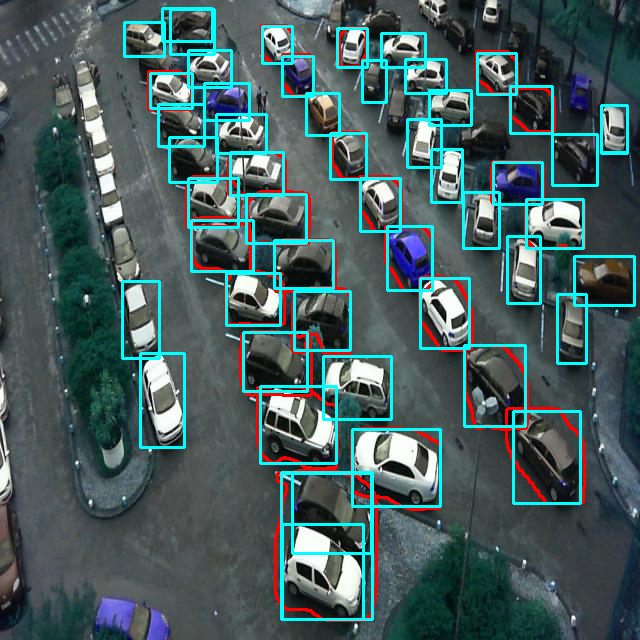

In [ ]:
import os
import cv2
import numpy as np
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import kagglehub

# Step 1: Download the dataset using kagglehub
dataset_path = kagglehub.dataset_download("ammarnassanalhajali/pklot-dataset")
print("Path to dataset files:", dataset_path)

# Find a sample image from dataset
def find_sample_image(root_path):
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith((".jpg", ".png", ".jpeg")):
                return os.path.join(root, file)
    return None

sample_image_path = find_sample_image(dataset_path)
if sample_image_path is None:
    raise FileNotFoundError("No image file found in the downloaded dataset.")

# Step 2: Load YOLOv8 model
yolo_model = YOLO('yolov8n.pt')  # Ensure this file exists or download the weights

# Step 3: Load Mask-RCNN model
maskrcnn = maskrcnn_resnet50_fpn(pretrained=True)
maskrcnn.eval()

# Step 4: Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
maskrcnn.to(device)

# Function to get parking slot masks
def get_parking_slot_masks(image):
    image_tensor = F.to_tensor(image).to(device)
    with torch.no_grad():
        prediction = maskrcnn([image_tensor])[0]

    masks = prediction['masks']
    scores = prediction['scores']

    threshold = 0.8
    slot_masks = []

    for i in range(len(masks)):
        if scores[i] > threshold:
            slot_masks.append(masks[i][0].cpu().numpy())

    return slot_masks

# Function to detect vehicles using YOLOv8
def detect_vehicles(image_path):
    results = yolo_model(image_path)
    return results[0].boxes.xyxy.cpu().numpy()

# Function to check intersection
def is_occupied(slot_mask, vehicle_boxes):
    for box in vehicle_boxes:
        x1, y1, x2, y2 = map(int, box)
        car_mask = np.zeros(slot_mask.shape, dtype=np.uint8)
        car_mask[y1:y2, x1:x2] = 1
        overlap = np.logical_and(car_mask, slot_mask)
        if np.sum(overlap) > 200:
            return True
    return False

# Main processing
def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    slot_masks = get_parking_slot_masks(image)
    vehicle_boxes = detect_vehicles(image_path)
    img = np.array(image)

    for mask in slot_masks:
        contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        color = (0, 255, 0)  # green by default
        if is_occupied(mask, vehicle_boxes):
            color = (0, 0, 255)  # red if occupied
        for cnt in contours:
            cv2.drawContours(img, [cnt], -1, color, 2)

    for box in vehicle_boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 0), 2)

        from google.colab.patches import cv2_imshow
    cv2_imshow(img)


# Run
if __name__ == '__main__':
    print("Processing image:", sample_image_path)
    process_image(sample_image_path)


Processing: /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2013-03-13_13_55_09_jpg.rf.ac6aec99078fd9a5c97aa9c8c5a2deee.jpg

image 1/1 /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2013-03-13_13_55_09_jpg.rf.ac6aec99078fd9a5c97aa9c8c5a2deee.jpg: 640x640 49 cars, 2 buss, 2 trucks, 248.9ms
Speed: 3.6ms preprocess, 248.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


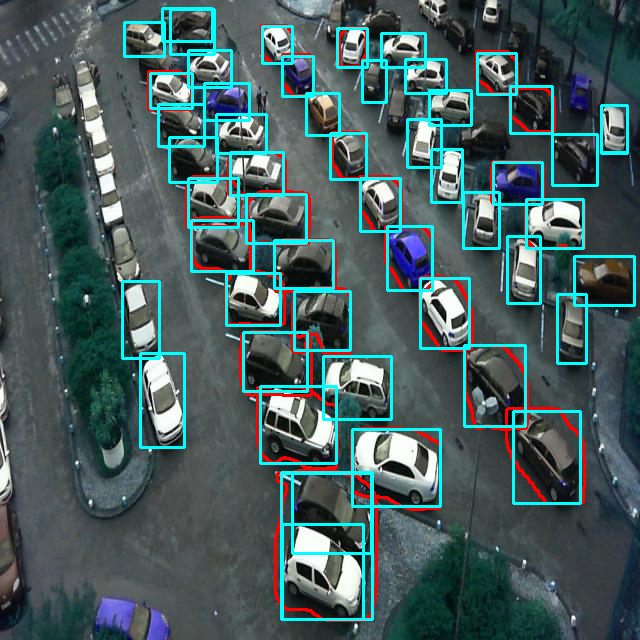

Processing: /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2012-12-22_19_25_16_jpg.rf.cc6b607598f1733cbc9a6f51acfed9de.jpg

image 1/1 /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2012-12-22_19_25_16_jpg.rf.cc6b607598f1733cbc9a6f51acfed9de.jpg: 640x640 (no detections), 231.0ms
Speed: 3.8ms preprocess, 231.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


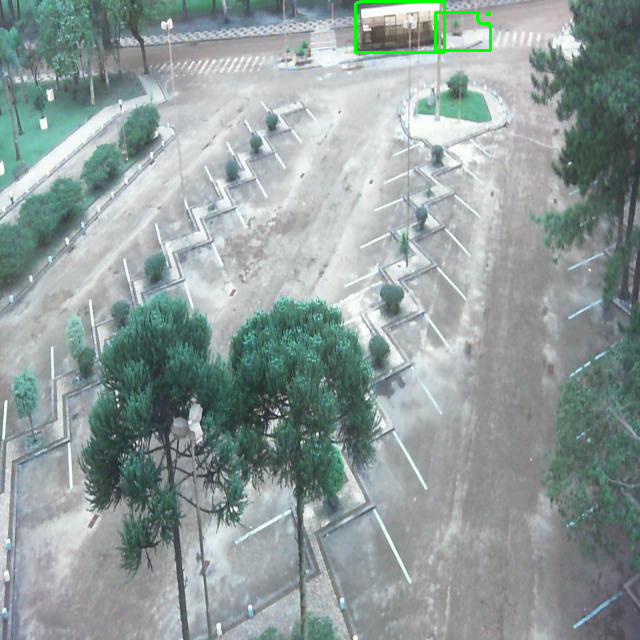

Processing: /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2013-04-12_13_15_07_jpg.rf.cef808bb6271b2447cff45df41643d68.jpg

image 1/1 /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2013-04-12_13_15_07_jpg.rf.cef808bb6271b2447cff45df41643d68.jpg: 640x640 29 cars, 3 buss, 246.6ms
Speed: 4.0ms preprocess, 246.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


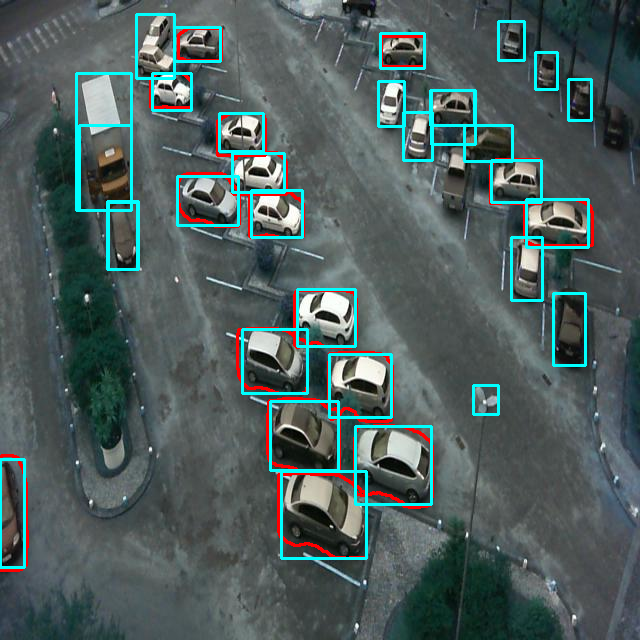

Processing: /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2013-03-19_11_30_06_jpg.rf.ccdf8d6ea5f60e45fd24186a289ffc60.jpg

image 1/1 /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2013-03-19_11_30_06_jpg.rf.ccdf8d6ea5f60e45fd24186a289ffc60.jpg: 640x640 1 person, 42 cars, 1 bus, 1 train, 241.4ms
Speed: 3.7ms preprocess, 241.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


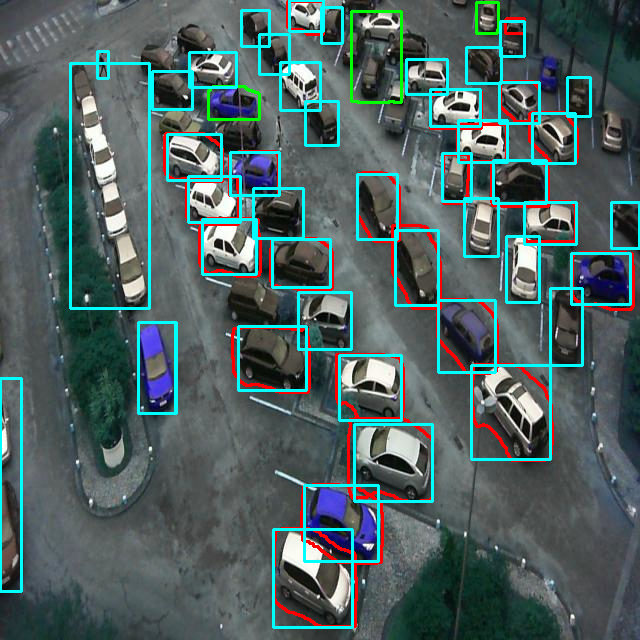

Processing: /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2013-02-22_07_05_01_jpg.rf.ae42ee42ef52cefb46fff8c31c80cad9.jpg

image 1/1 /root/.cache/kagglehub/datasets/ammarnassanalhajali/pklot-dataset/versions/1/valid/2013-02-22_07_05_01_jpg.rf.ae42ee42ef52cefb46fff8c31c80cad9.jpg: 640x640 1 person, 6 cars, 1 truck, 258.8ms
Speed: 3.8ms preprocess, 258.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


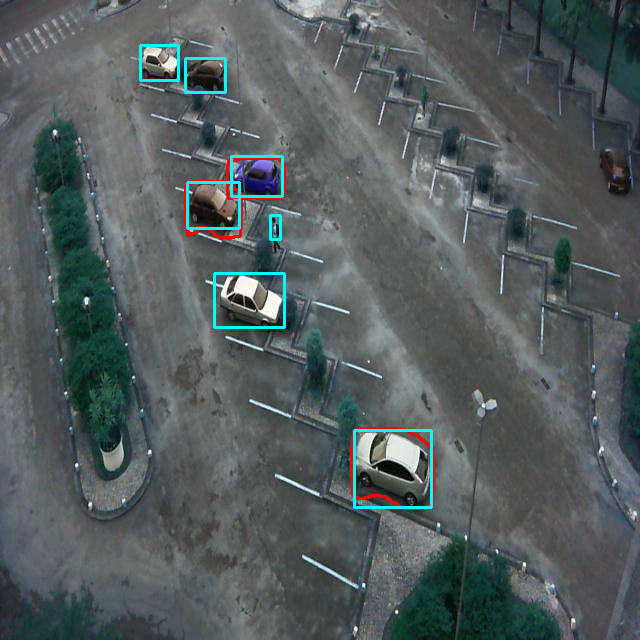

In [ ]:
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".jpg"):
            image_paths.append(os.path.join(root, file))

# Predict on first 5 images
for path in image_paths[:5]:
    print("Processing:", path)
    process_image(path)
